In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask import delayed, compute
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Floa

In [2]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict, 256)

In [3]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7999'})

cluster.scale(jobs=4)
cluster

In [4]:
client = Client(cluster)
client

Client Scheduler: tcp://172.22.179.3:7223 Dashboard: /proxy/7999/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
# rdm_idx = pd.date_range(start='2019-09-06 23:58:30', periods=60, tz='UTC', freq='S')  # for P3B

start = '2019-09-06 23:56:30'
end = '2019-09-07 0:04:30'
aircraft = 'P3B'
aircraft2 = 'P3B'

In [7]:
store1 = f"{path_data}/zarr/combined_psd_{aircraft}_350_825.zarr"
store2 = f"{path_data}/zarr/combined_psd_{aircraft}_800_1200.zarr"
store3 = f"{path_data}/zarr/2DS10_{aircraft2}.zarr"
store4 = f"{path_data}/zarr/HVPS_{aircraft2}.zarr"

In [8]:
xr_400 = xr.open_zarr(store1)
xr_800 = xr.open_zarr(store2)
xr_2ds = xr.open_zarr(store3)
xr_2ds = xr_2ds.assign(dd=(["diameter"], np.array(xr_2ds.attrs['dsizes'])))

xr_hvps = xr.open_zarr(store4)
xr_hvps = xr_hvps.assign(dd=(["diameter"], np.array(xr_hvps.attrs['dsizes'])))

In [9]:
d_tile = np.tile(xr_400.diameter, [np.shape(xr_400.merge_psd.values)[0], 1])
dd_tile = np.tile(xr_400.dd, [np.shape(xr_400.merge_psd.values)[0], 1])

d_tile_800 = np.tile(xr_800.diameter, [np.shape(xr_800.merge_psd.values)[0], 1])
dd_tile_800 = np.tile(xr_800.dd, [np.shape(xr_800.merge_psd.values)[0], 1])

In [10]:
d_2ds = np.tile(xr_2ds.diameter, [np.shape(xr_2ds.pds.values)[0], 1])
dd_2ds = np.tile(xr_2ds.dd, [np.shape(xr_2ds.pds.values)[0], 1])

In [11]:
d_hvps = np.tile(xr_hvps.diameter, [np.shape(xr_hvps.pds.values)[0], 1])
dd_hvps = np.tile(xr_hvps.dd, [np.shape(xr_hvps.pds.values)[0], 1])

In [12]:
lwc_400 =(np.pi / (6.  * 1000.)) * np.sum(xr_400.merge_psd  * d_tile ** 3 * dd_tile, axis=1)
lwc_800 =(np.pi / (6.  * 1000.)) * np.sum(xr_800.merge_psd * d_tile_800 ** 3 * dd_tile_800, axis=1)

In [13]:
lwc_2ds = (np.pi / (6.  * 1000.)) * np.sum((xr_2ds.pds * 1e6) * (d_2ds * 1e-3) ** 3 * (dd_2ds * 1e-3), 
                                           axis=1)

In [14]:
lwc_hvps = (np.pi / (6.  * 1000.)) * np.sum((xr_hvps.pds * 1e6) * (d_hvps * 1e-3) ** 3 * (dd_hvps * 1e-3), 
                                            axis=1)

In [15]:
LWC_400 = lwc_400.sel(time=slice(start, end))
LWC_800 = lwc_800.sel(time=slice(start, end))
LWC_plane = xr_400.lwc_plane.sel(time=slice(start,end))
LWC_2ds = lwc_2ds.sel(time=slice(start, end))
LWC_hvps = lwc_hvps.sel(time=slice(start, end))

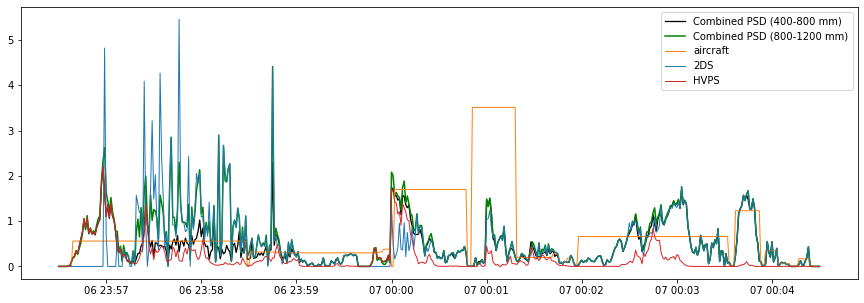

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(LWC_400.time, LWC_400, label='Combined PSD (400-800 mm)' , c='k', lw=1.3)
ax.plot(LWC_800.time, LWC_800, label='Combined PSD (800-1200 mm)', c='green')
ax.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)
ax.legend()

In [17]:
_upper = 800
_lower = 400

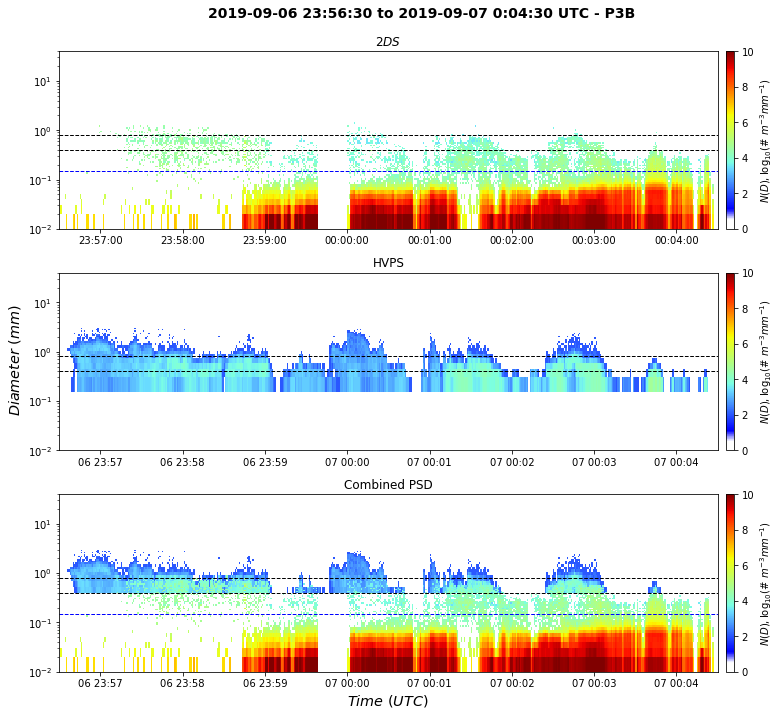

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

cbar = ax3.pcolormesh(xr_400.time.sel(time=slice(start, end)).values, 
                      xr_400.diameter.values, 
                      np.log10(xr_400.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

cbar2 = ax1.pcolormesh(xr_2ds.time.sel(time=slice(start, end)).values, 
                       xr_2ds.diameter * 1e-3, 
                       np.log10(xr_2ds.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)

cbar3 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)).values, 
                       xr_hvps.diameter * 1e-3, 
                       np.log10(xr_hvps.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)    

plt.colorbar(cbar, ax=ax1, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar2, ax=ax2, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar3, ax=ax3, pad=0.01, aspect=20,label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

ax2.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')


ax3.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax3.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax2.set_title('HVPS')
ax3.set_title('Combined PSD')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax2.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax3.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.set_ylim(0.01, 40)
ax3.set_ylim(0.01, 40)

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
plt.tight_layout()

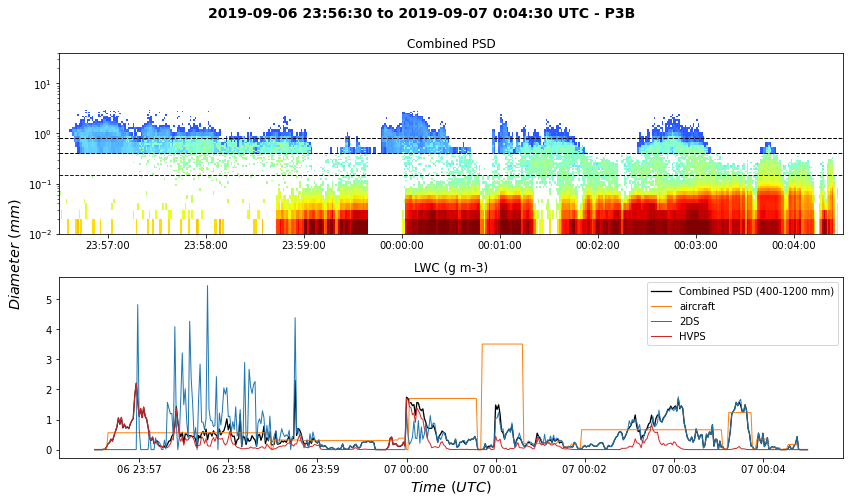

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), constrained_layout=True)

cbar = ax1.pcolormesh(xr_400.time.sel(time=slice(start, end)).values, 
                      xr_400.diameter.values, 
                      np.log10(xr_400.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

ax2.plot(LWC_400.time, LWC_400, label='Combined PSD (400-1200 mm)' , c='k', lw=1.3)
ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# fig.colorbar(cbar, ax=[ax1], aspect=50, pad=0.02, 
#              label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_title('LWC (g m-3)')
ax1.set_title('Combined PSD')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [20]:
_upper = 1200
_lower = 800

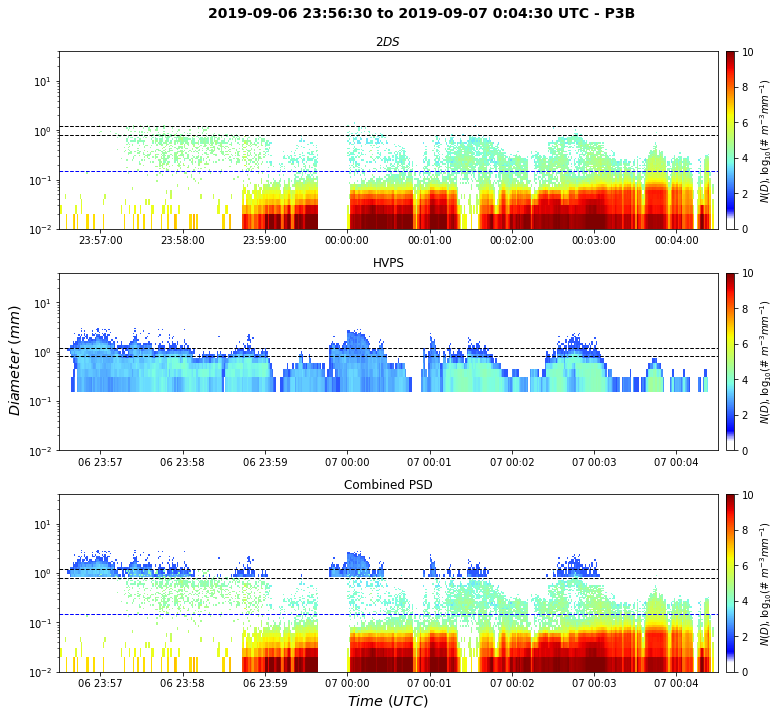

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

cbar = ax3.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

cbar2 = ax1.pcolormesh(xr_2ds.time.sel(time=slice(start, end)).values, 
                       xr_2ds.diameter * 1e-3, 
                       np.log10(xr_2ds.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)

cbar3 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)).values, 
                       xr_hvps.diameter * 1e-3, 
                       np.log10(xr_hvps.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)    

plt.colorbar(cbar, ax=ax1, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar2, ax=ax2, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar3, ax=ax3, pad=0.01, aspect=20,label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

ax2.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')


ax3.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax3.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax2.set_title('HVPS')
ax3.set_title('Combined PSD')
ax1.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax2.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax3.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.set_ylim(0.01, 40)
ax3.set_ylim(0.01, 40)

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
plt.tight_layout()

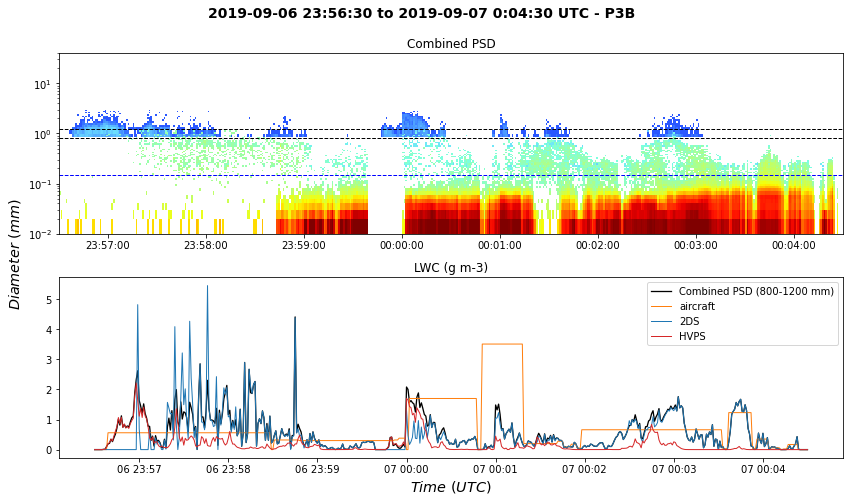

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), constrained_layout=True)

cbar = ax1.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

ax2.plot(LWC_800.time, LWC_800, label='Combined PSD (800-1200 mm)' , c='k', lw=1.3)
ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# fig.colorbar(cbar, ax=[ax1], aspect=50, pad=0.02, 
#              label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_title('LWC (g m-3)')
ax1.set_title('Combined PSD')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [23]:
lwc_2ds = (np.pi / (6.  * 1000.)) * (xr_2ds.pds * 1e6) * (d_2ds * 1e-3) ** 3 * (dd_2ds * 1e-3)

In [24]:
lwc_hvps = (np.pi / (6.  * 1000.)) * (xr_hvps.pds * 1e6) * (d_hvps * 1e-3) ** 3 * (dd_hvps * 1e-3)

Text(0.5, 1.0, '2DS')

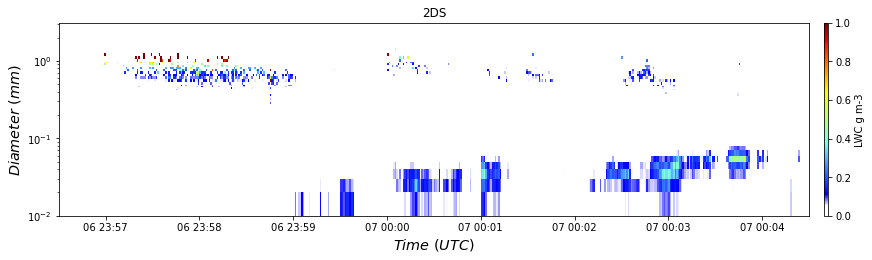

In [25]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_2ds.time.sel(time=slice(start, end)).values, 
                      lwc_2ds.diameter.values * 1e-3, 
                      lwc_2ds.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_yscale('log')
ax.set_title('2DS')

(0.0, 4.0)

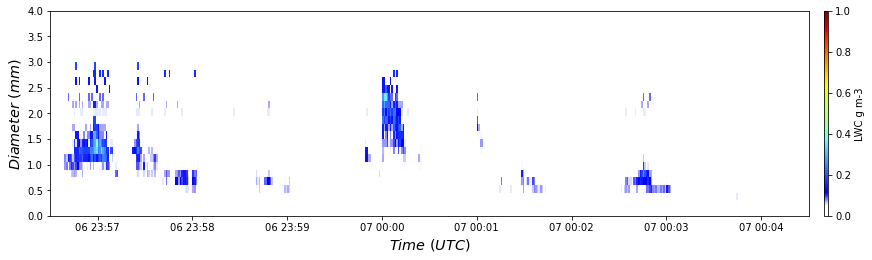

In [26]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_hvps.time.sel(time=slice(start, end)).values, 
                      lwc_hvps.diameter.values * 1e-3, 
                      lwc_hvps.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_ylim(0, 4)

# 2ds from 10 to 1000 um


In [43]:
ds_dmin = 10
ds_dmax = 825
hvps_dmin = 350
hvps_dmax = 47000

In [44]:
d_2ds = np.tile(xr_2ds.diameter.sel(diameter=slice(ds_dmin, ds_dmax)), 
                [np.shape(xr_2ds.pds.sel(diameter=slice(ds_dmin, ds_dmax)).values)[0], 1])

In [45]:
dd_2ds = np.tile(xr_2ds.dd.sel(diameter=slice(ds_dmin, ds_dmax)), 
                [np.shape(xr_2ds.pds.sel(diameter=slice(ds_dmin, ds_dmax)).values)[0], 1])

In [46]:
d_hvps = np.tile(xr_hvps.diameter.sel(diameter=slice(hvps_dmin, hvps_dmax)), 
                [np.shape(xr_hvps.pds.sel(diameter=slice(hvps_dmin, hvps_dmax)).values)[0], 1])

dd_hvps = np.tile(xr_hvps.dd.sel(diameter=slice(hvps_dmin, hvps_dmax)),
                 [np.shape(xr_hvps.pds.sel(diameter=slice(hvps_dmin, hvps_dmax)).values)[0], 1])

In [47]:
lwc_2ds = (np.pi / (6.  * 1000.)) * np.sum((xr_2ds.pds.sel(diameter=slice(ds_dmin, ds_dmin))) * (d_2ds * 1e-3) 
                                           ** 3 * (dd_2ds * 1e-3), axis=1)

In [57]:
lwc_2ds.diameter

<xarray.DataArray 'diameter' (diameter: 41)>
array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.,
       130., 140., 150., 160., 170., 180., 190., 200., 215., 235., 255., 275.,
       295., 315., 335., 355., 375., 395., 415., 435., 455., 475., 495., 530.,
       580., 630., 680., 730., 780.])
Coordinates:
  * diameter  (diameter) float64 10.0 20.0 30.0 40.0 ... 630.0 680.0 730.0 780.0

In [48]:
lwc_hvps = (np.pi / (6.  * 1000.)) * np.sum((xr_hvps.pds.sel(diameter=slice(hvps_dmin, hvps_dmax)) * 1e6) * 
                                            (d_hvps * 1e-3) ** 3 * (dd_hvps * 1e-3), axis=1)

In [49]:
LWC_400 = lwc_400.sel(time=slice(start, end))
LWC_800 = lwc_800.sel(time=slice(start, end))
LWC_plane = xr_400.lwc_plane.sel(time=slice(start,end))
LWC_2ds = lwc_2ds.sel(time=slice(start, end))
LWC_hvps = lwc_hvps.sel(time=slice(start, end))

In [50]:
_lower = 400
_upper = 1200

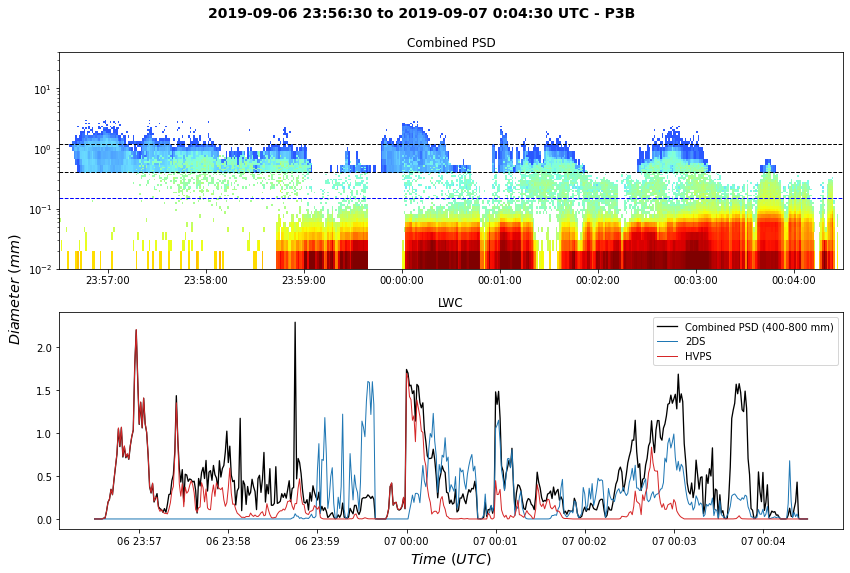

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

cbar = ax1.pcolormesh(xr_400.time.sel(time=slice(start, end)).values, 
                      xr_400.diameter.values, 
                      np.log10(xr_400.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

ax2.plot(LWC_400.time, LWC_400, label='Combined PSD (400-800 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# fig.colorbar(cbar, ax=[ax1], aspect=50, pad=0.02, 
#              label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_title('LWC')
ax1.set_title('Combined PSD')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

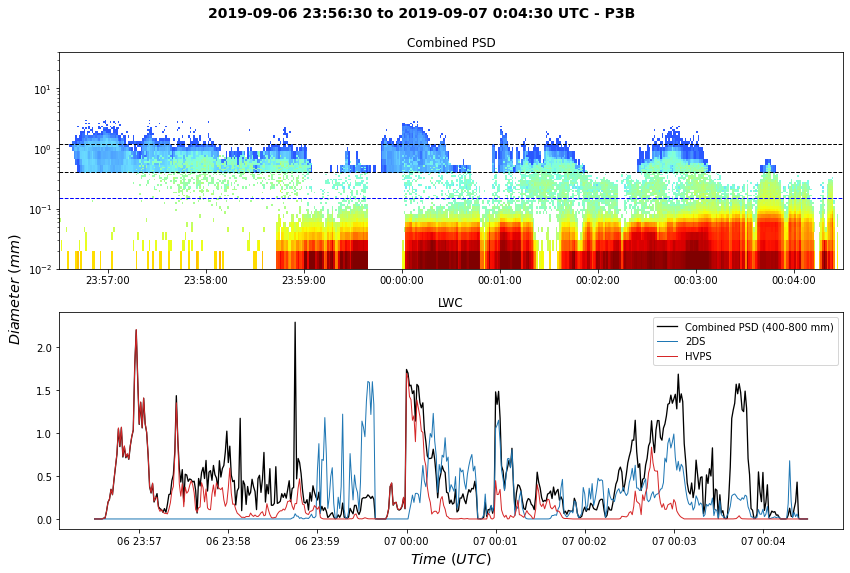

In [63]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

cbar = ax1.pcolormesh(xr_400.time.sel(time=slice(start, end)).values, 
                      xr_400.diameter, 
                      np.log10(xr_400.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

ax2.plot(LWC_400.time, LWC_400, label='Combined PSD (400-800 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# fig.colorbar(cbar, ax=[ax1], aspect=50, pad=0.02, 
#              label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_400.time.sel(time=slice(start, end)).min(),  
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_400.time.sel(time=slice(start, end)).min(), 
           xr_400.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_title('LWC')
ax1.set_title('Combined PSD')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [64]:
lwc_hvps

<xarray.DataArray 'pds' (time: 528635)>
dask.array<mul, shape=(528635,), dtype=float64, chunksize=(33040,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-08-24T21:55:08 ... 2019-10-05T07:28:23

AttributeError: 'DataArray' object has no attribute 'diameter'

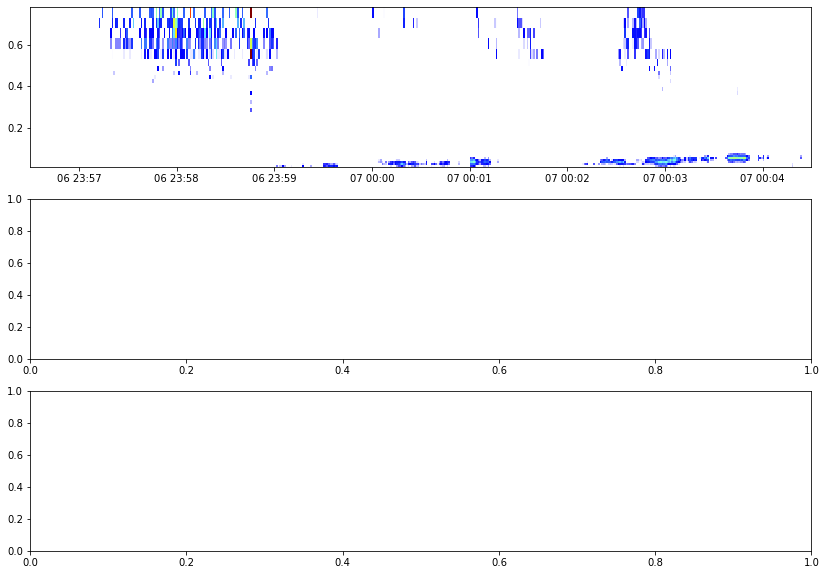

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

cbar = ax1.pcolormesh(lwc_2ds.time.sel(time=slice(start, end)).values, 
                      lwc_2ds.diameter * 1e-3, 
                      lwc_2ds.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)

cbar2 = ax2.pcolormesh(lwc_hvps.time.sel(time=slice(start, end)).values, 
                      lwc_hvps.diameter * 1e-3, 
                      lwc_hvps.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)

cbar3 = ax3.pcolormesh(xr_hvps.time.sel(time=slice(start, end)).values, 
                       xr_hvps.diameter * 1e-3, 
                       np.log10(xr_hvps.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)    

plt.colorbar(cbar, ax=ax1, pad=0.01, aspect=50, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar2, ax=ax2, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar3, ax=ax3, pad=0.01, aspect=20,label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')

ax2.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')


ax3.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax3.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax2.set_title('HVPS')
ax3.set_title('Combined PSD')
ax1.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax2.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax3.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.set_ylim(0.01, 40)
ax3.set_ylim(0.01, 40)

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

In [53]:
lwc_2ds = (np.pi / (6.  * 1000.)) * (xr_2ds.pds.sel(diameter=slice(10, 825))* 1e6) * (d_2ds * 1e-3) ** 3 * (dd_2ds * 1e-3)

In [37]:
lwc_hvps = (np.pi / (6.  * 1000.)) * (xr_hvps.pds.sel(diameter=slice(300, 47000)) * 1e6) * (d_hvps * 1e-3) ** 3 * (dd_hvps * 1e-3)

(0.01, 2)

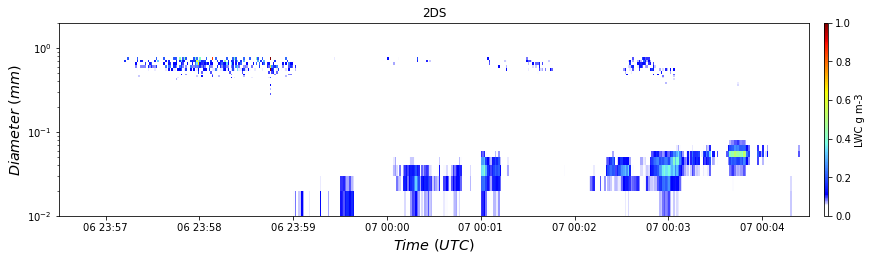

In [38]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_2ds.time.sel(time=slice(start, end)).values, 
                      lwc_2ds.diameter.values * 1e-3, 
                      lwc_2ds.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_yscale('log')
ax.set_title('2DS')
ax.set_ylim(1e-2, 2)

(0.0, 4.0)

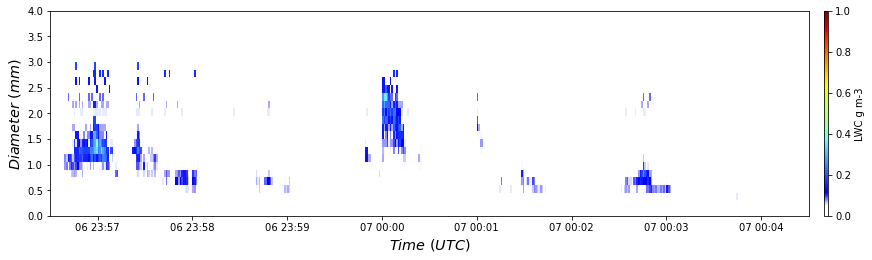

In [39]:
fig, ax = plt.subplots(figsize=(12, 3.5), constrained_layout=True)

cbar = ax.pcolormesh(lwc_hvps.time.sel(time=slice(start, end)).values, 
                      lwc_hvps.diameter.values * 1e-3, 
                      lwc_hvps.sel(time=slice(start, end)).T.values, 
                      vmin=0, vmax=1, cmap=my_cmap)
fig.colorbar(cbar, ax=[ax], aspect=50, pad=0.02, label='LWC g m-3')  # .set_ticks(np.arange(0,,1))
ax.set_ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax.set_ylim(0, 4)

In [40]:
_upper = 1200
_lower = 800

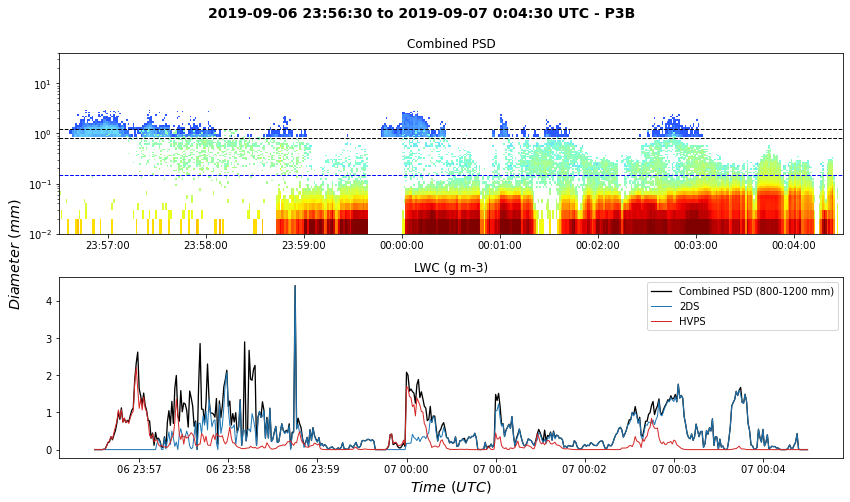

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), constrained_layout=True)

cbar = ax1.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

ax2.plot(LWC_800.time, LWC_800, label='Combined PSD (800-1200 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

# fig.colorbar(cbar, ax=[ax1], aspect=50, pad=0.02, 
#              label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='b', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_title('LWC (g m-3)')
ax1.set_title('Combined PSD')
ax1.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

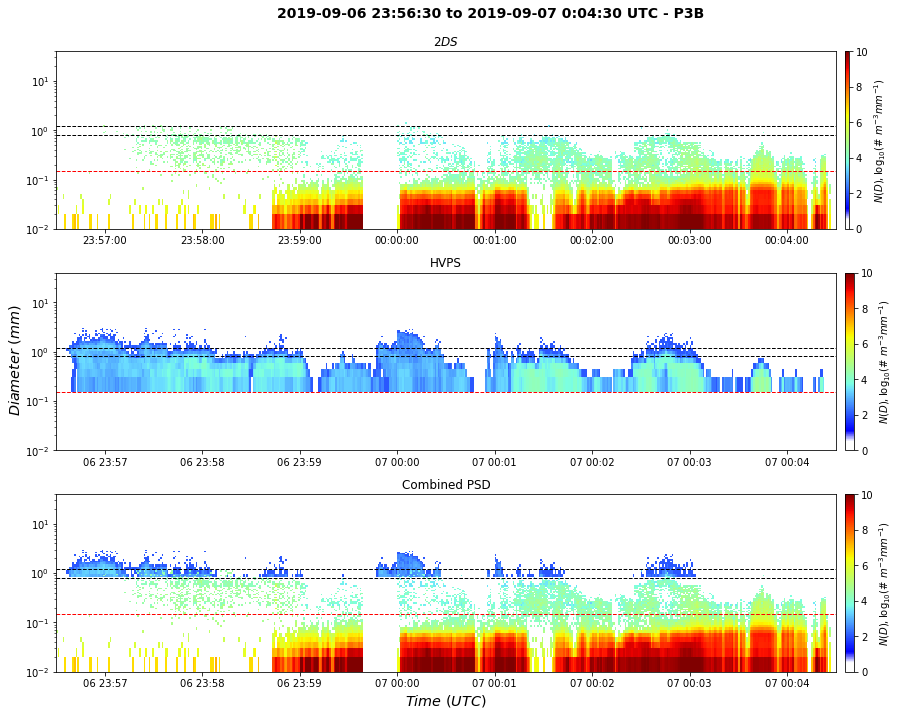

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

cbar = ax3.pcolormesh(xr_800.time.sel(time=slice(start, end)).values, 
                      xr_800.diameter.values, 
                      np.log10(xr_800.merge_psd.sel(time=slice(start, end)).T.values), 
                      vmin=0, vmax=10, cmap=my_cmap)

cbar2 = ax1.pcolormesh(xr_2ds.time.sel(time=slice(start, end)).values, 
                       xr_2ds.diameter * 1e-3, 
                       np.log10(xr_2ds.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)

cbar3 = ax2.pcolormesh(xr_hvps.time.sel(time=slice(start, end)).values, 
                       xr_hvps.diameter * 1e-3, 
                       np.log10(xr_hvps.pds.sel(time=slice(start, end)).T.values * 1e6), vmin=0,
                       vmax=10, cmap=my_cmap)    

plt.colorbar(cbar, ax=ax1, pad=0.01, aspect=50, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar2, ax=ax2, pad=0.01, aspect=20, label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))
plt.colorbar(cbar3, ax=ax3, pad=0.01, aspect=20,label='$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $')  # .set_ticks(np.arange(0,,1))


ax1.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax1.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')

ax2.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax2.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')


ax3.hlines(_upper * 1e-3, xr_800.time.sel(time=slice(start, end)).min(),  
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(_lower * 1e-3,  xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='k', 
          linestyles='--')

ax3.hlines(xr_hvps.diameter.min() * 1e-3, 
           xr_800.time.sel(time=slice(start, end)).min(), 
           xr_800.time.sel(time=slice(start, end)).max(), linewidth=1, color='r', linestyles='--')

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax3.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax2.set_title('HVPS')
ax3.set_title('Combined PSD')
ax1.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax2.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax3.set_xlim(xr_800.time.sel(time=slice(start, end)).min(), xr_800.time.sel(time=slice(start, end)).max())
ax1.set_ylim(0.01, 40)
ax2.set_ylim(0.01, 40)
ax3.set_ylim(0.01, 40)

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()

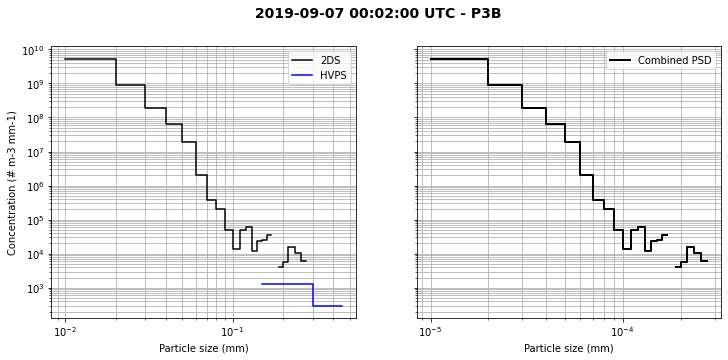

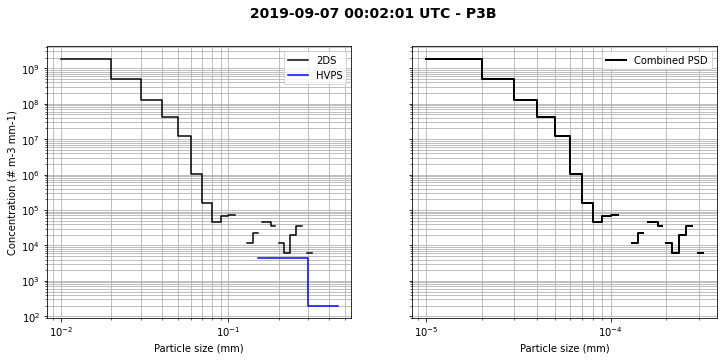

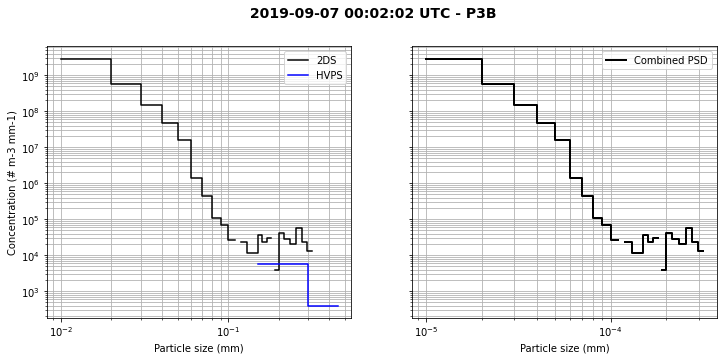

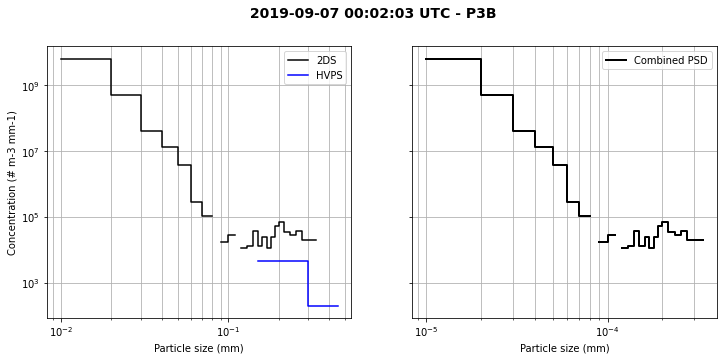

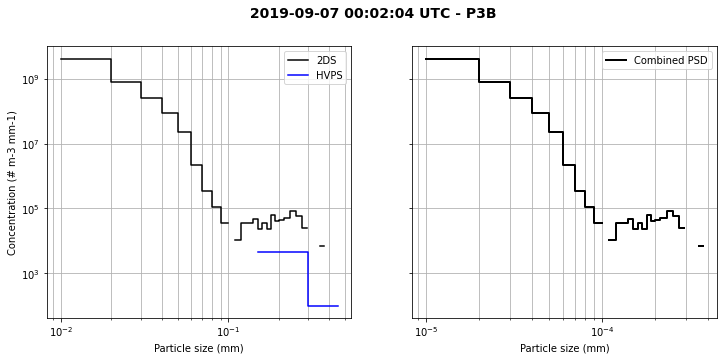

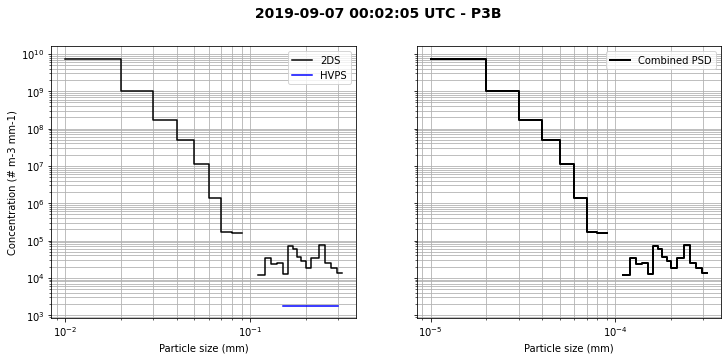

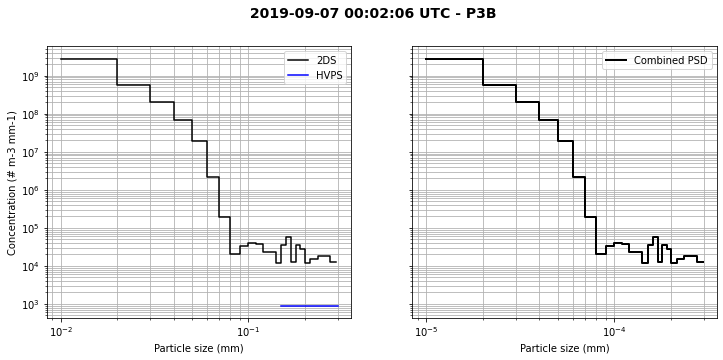

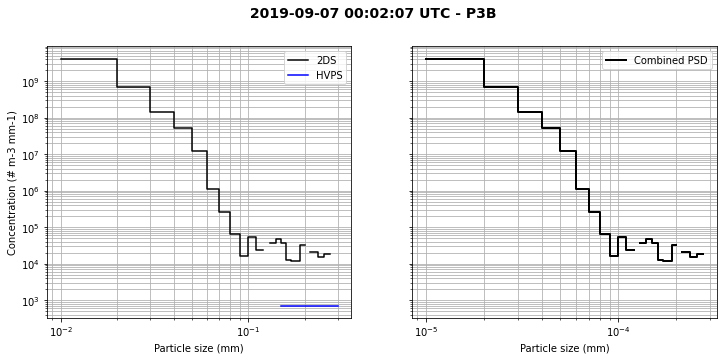

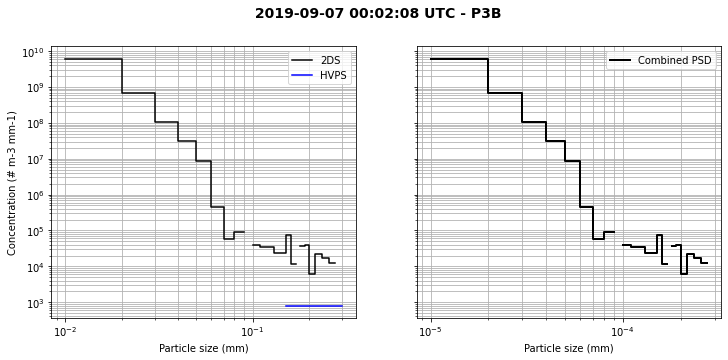

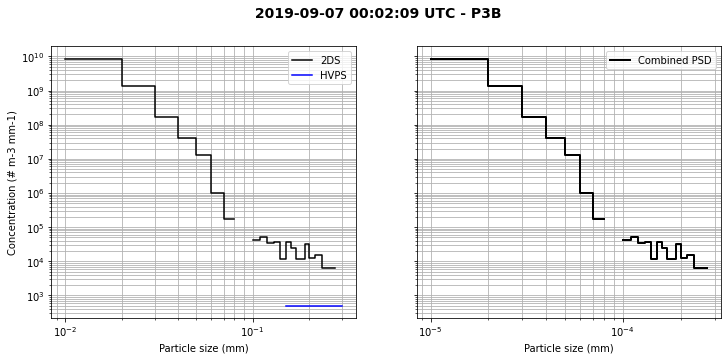

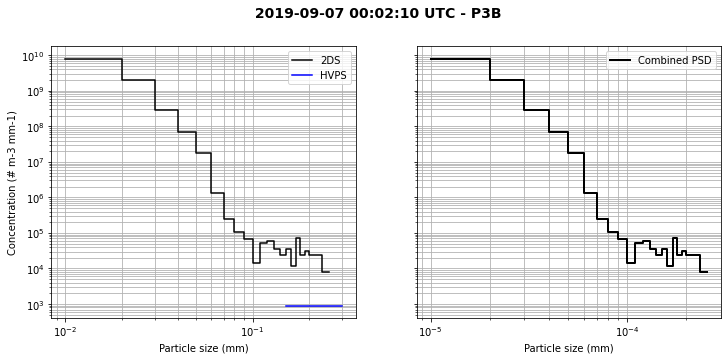

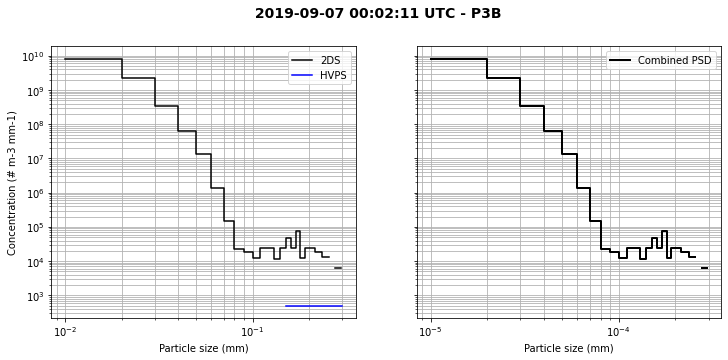

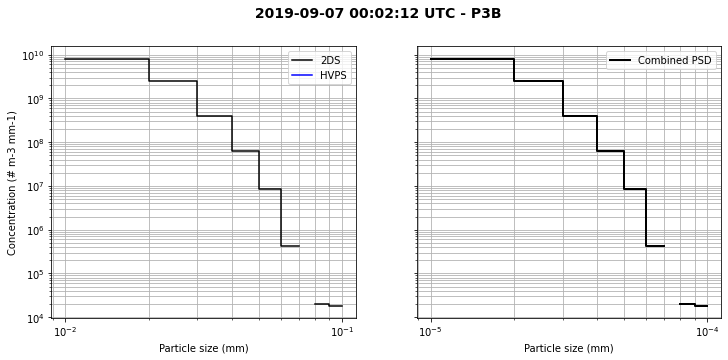

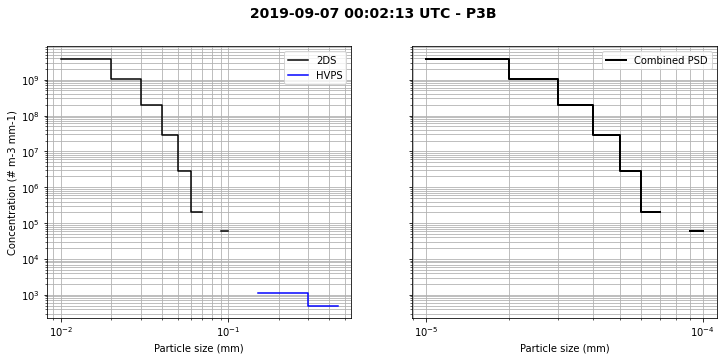

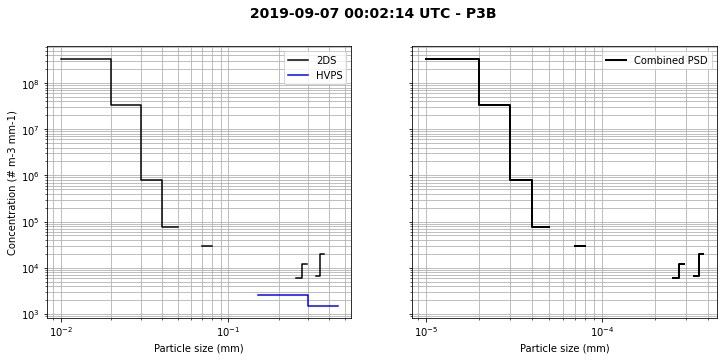

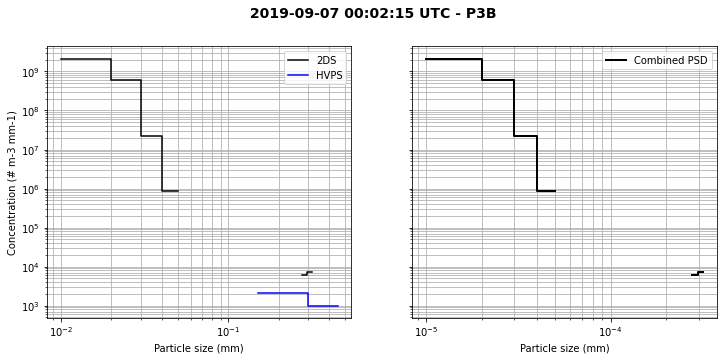

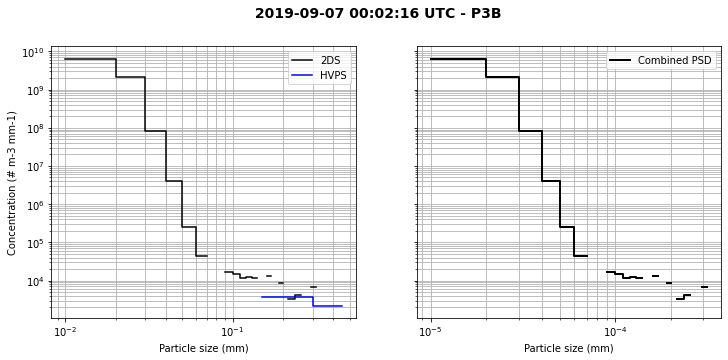

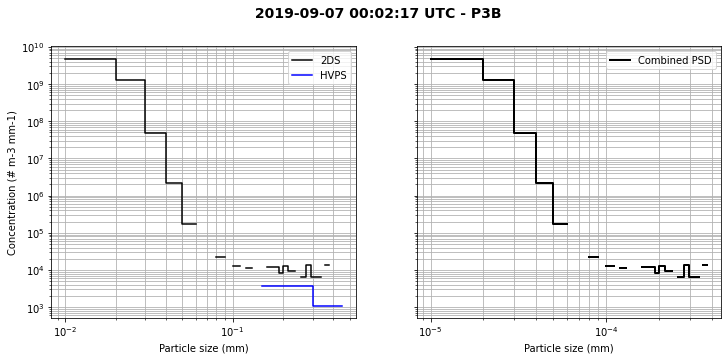

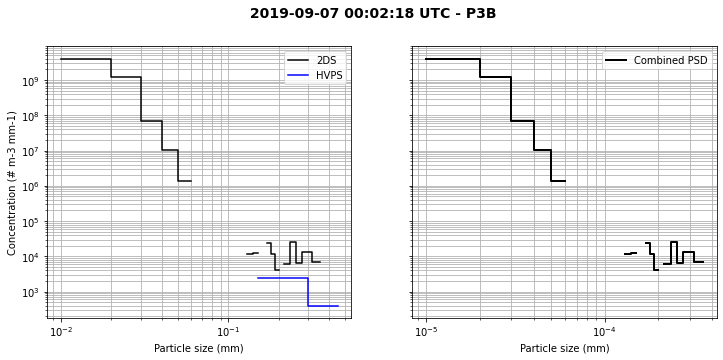

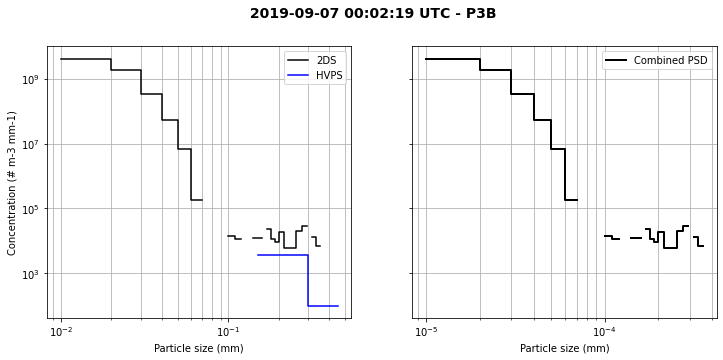

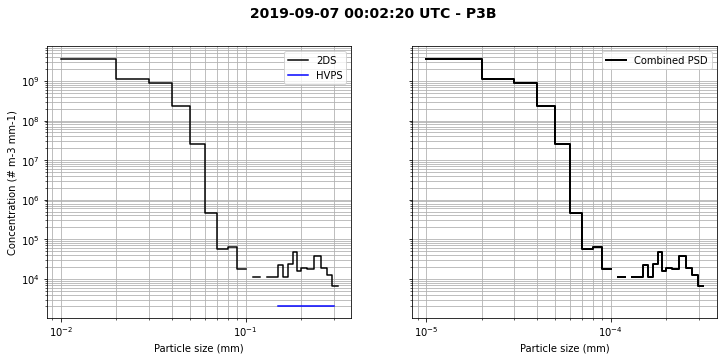

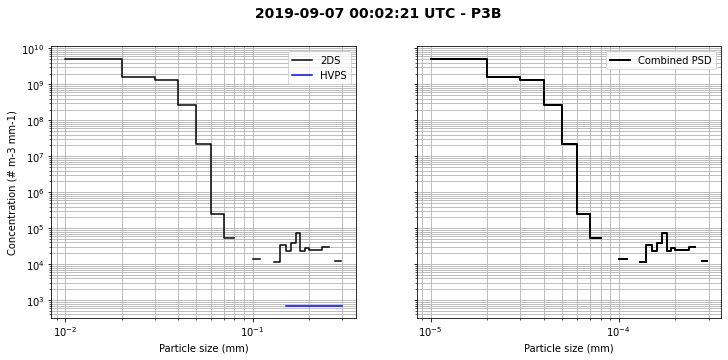

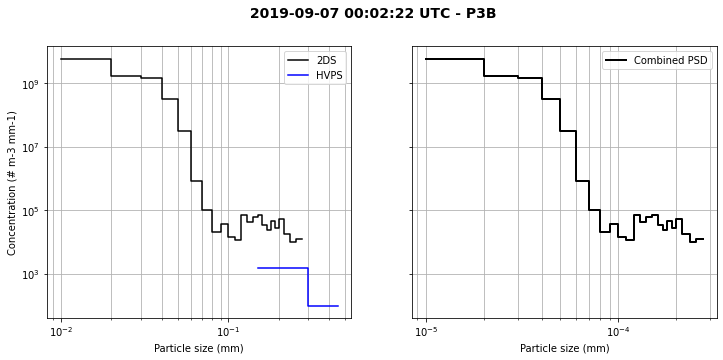

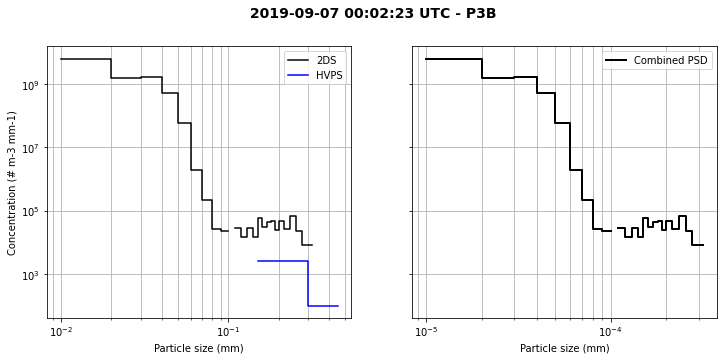

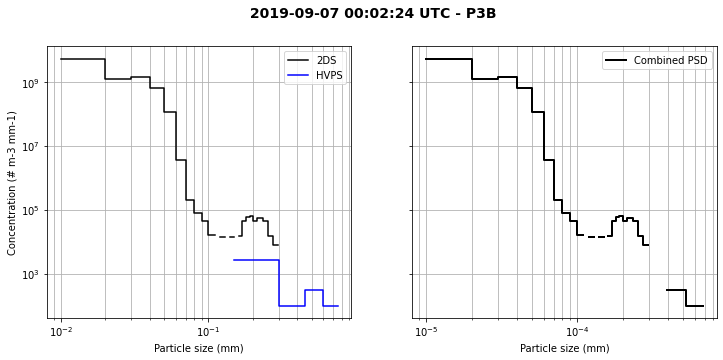

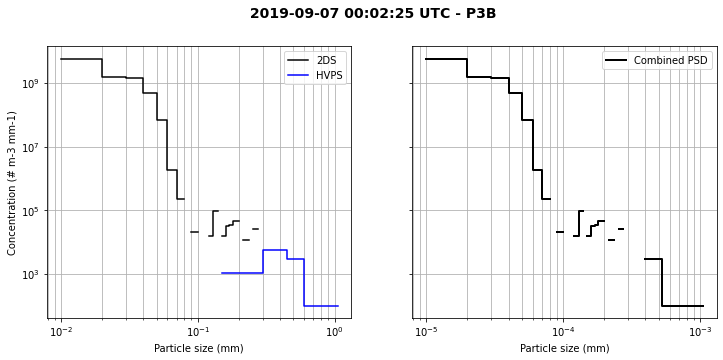

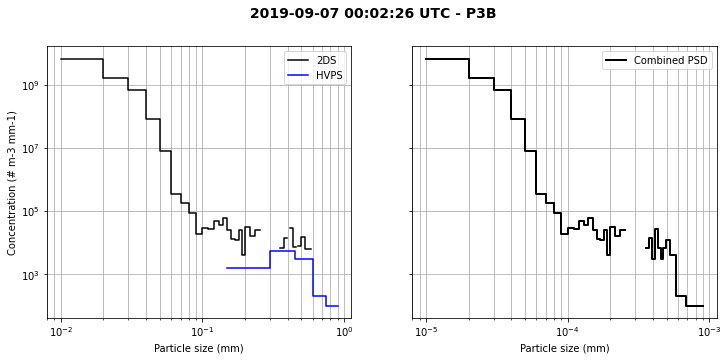

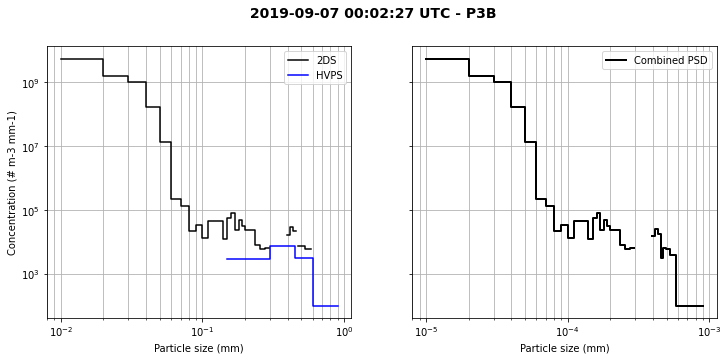

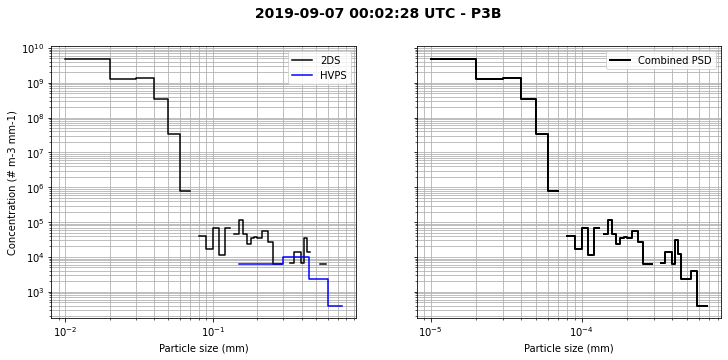

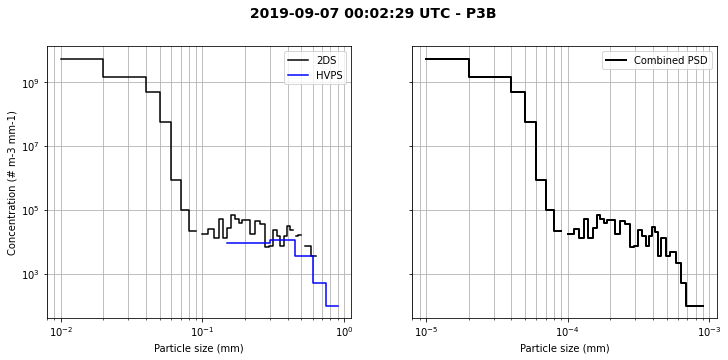

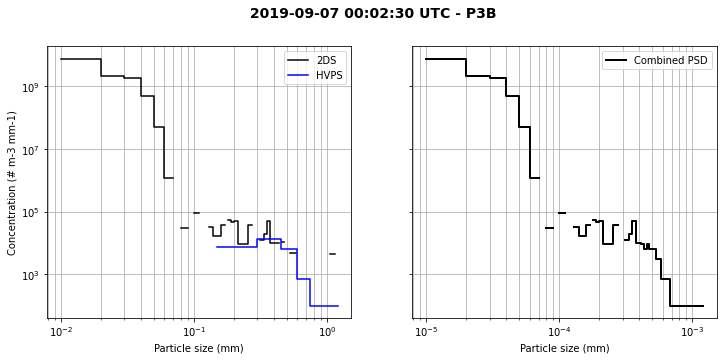

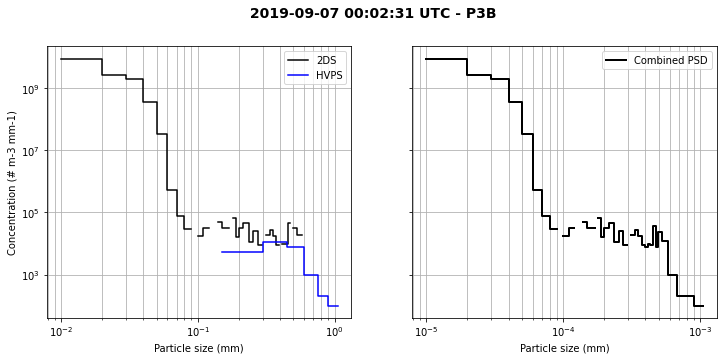

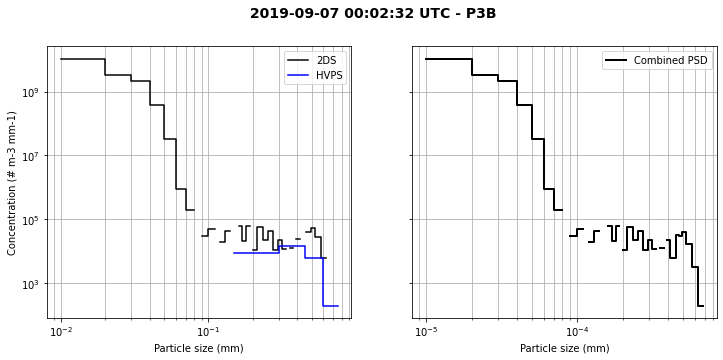

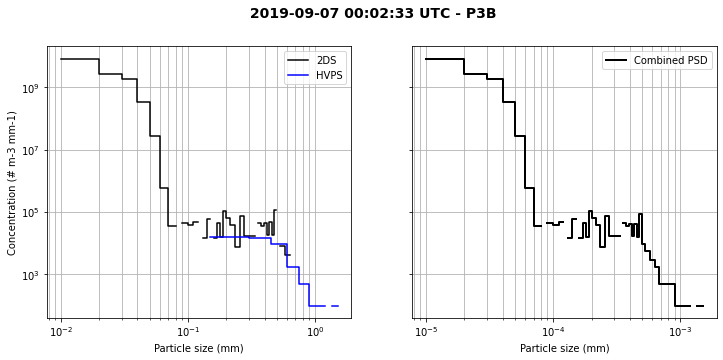

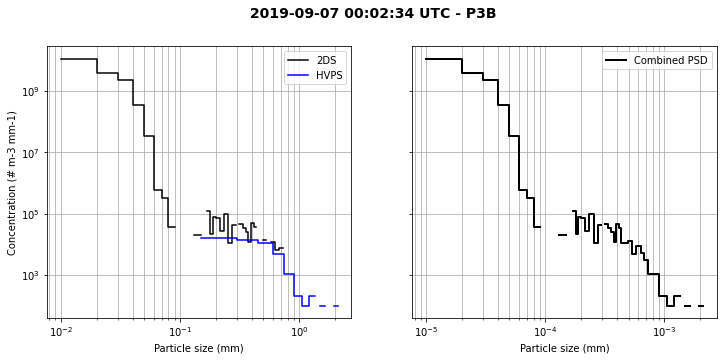

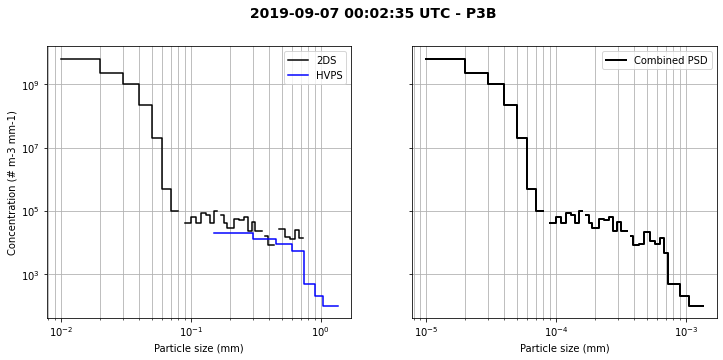

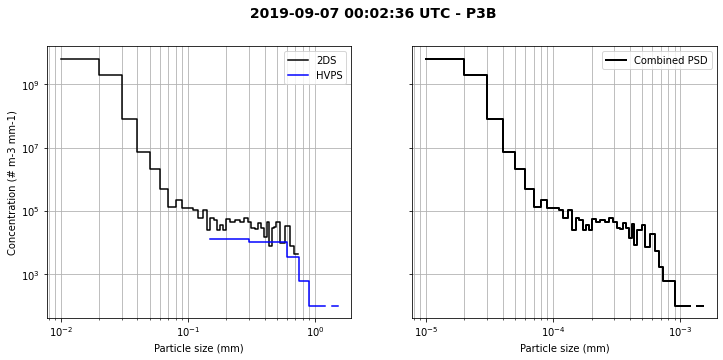

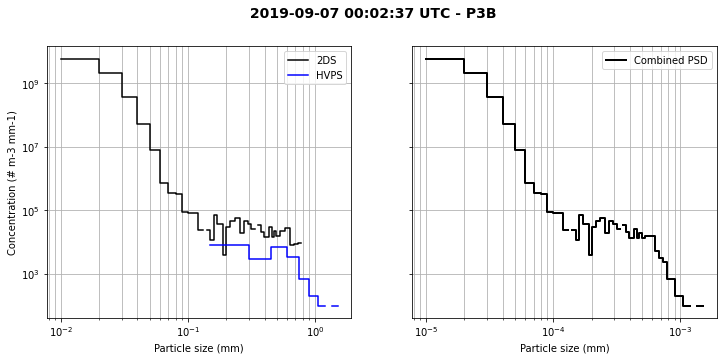

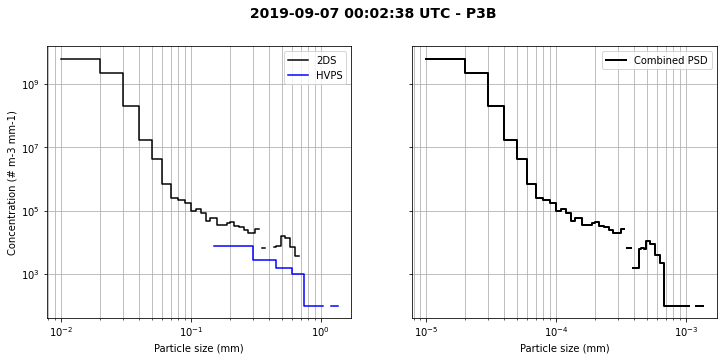

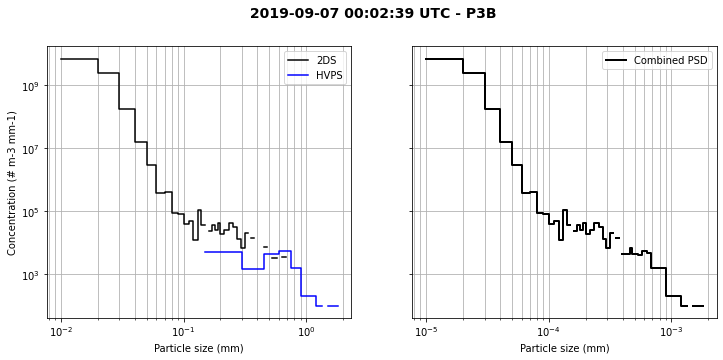

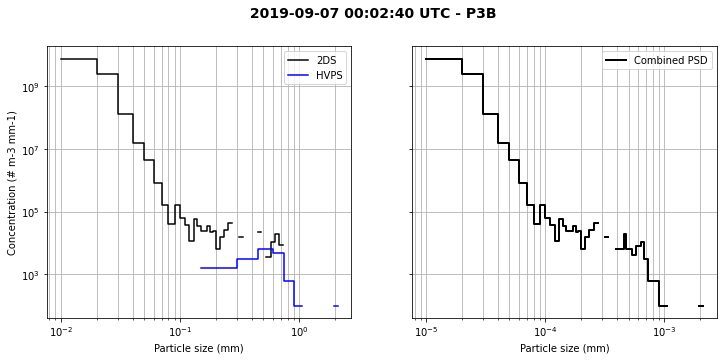

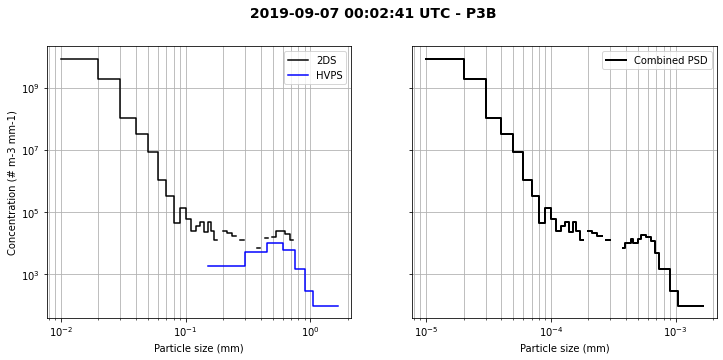

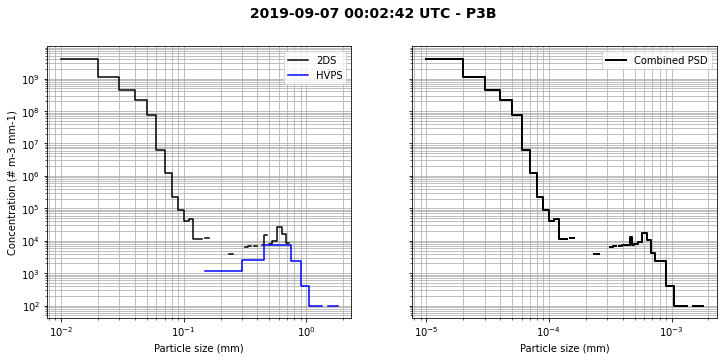

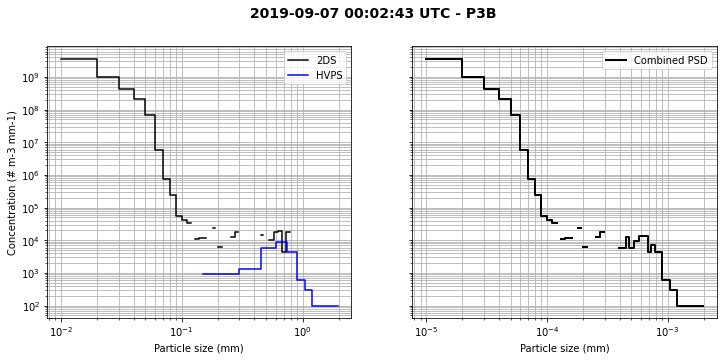

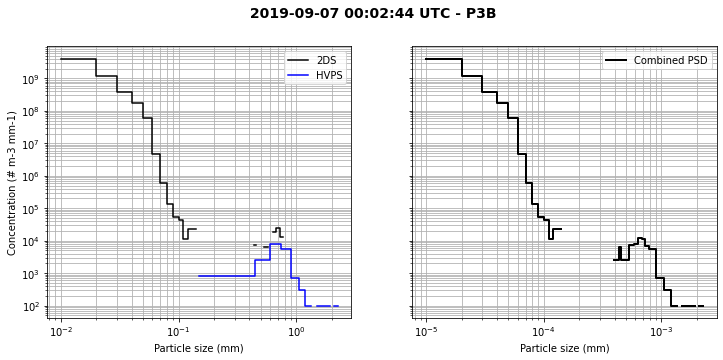

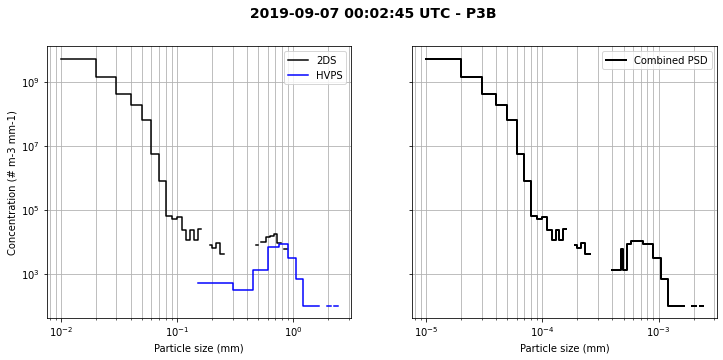

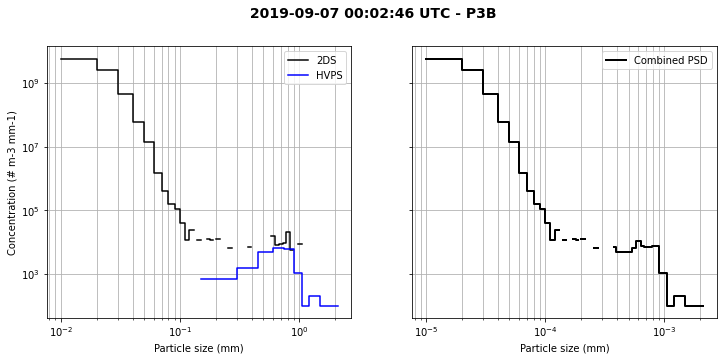

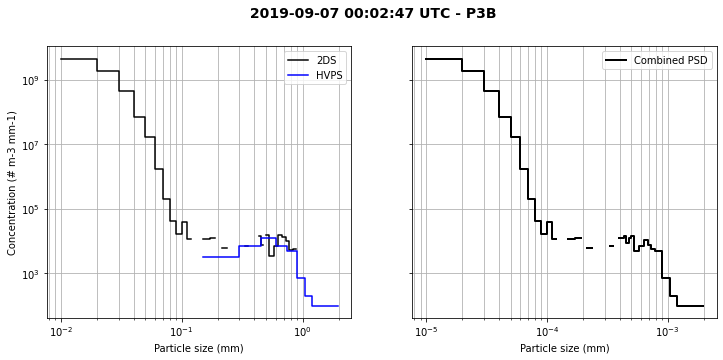

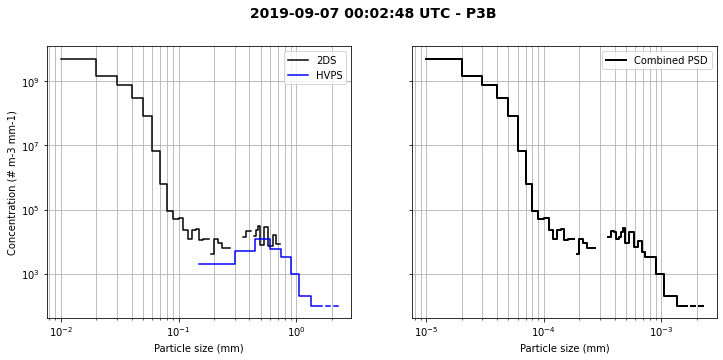

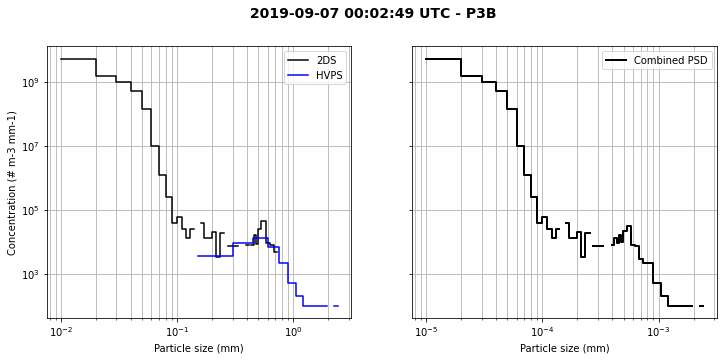

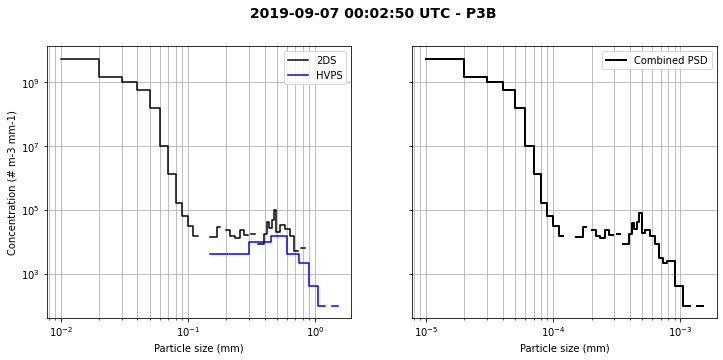

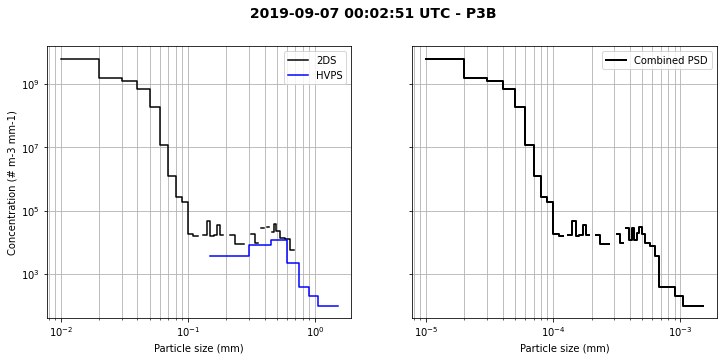

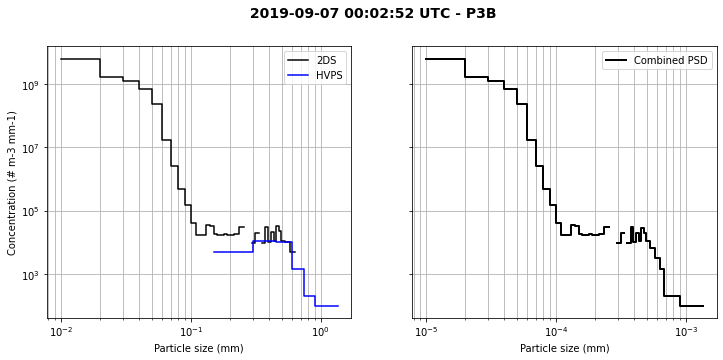

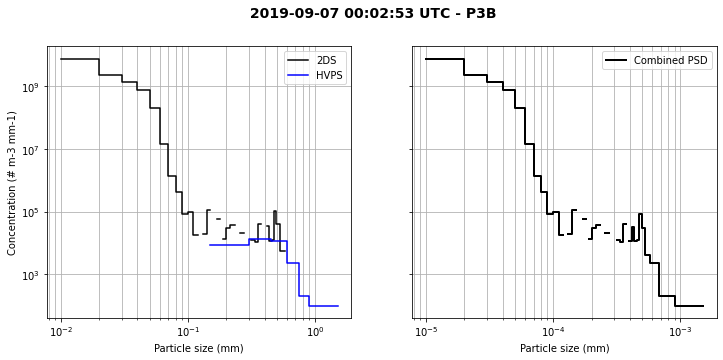

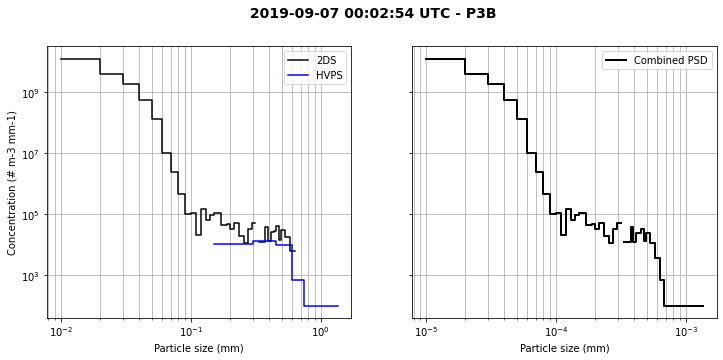

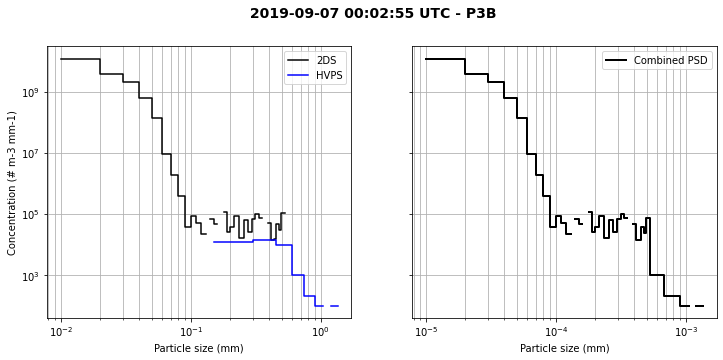

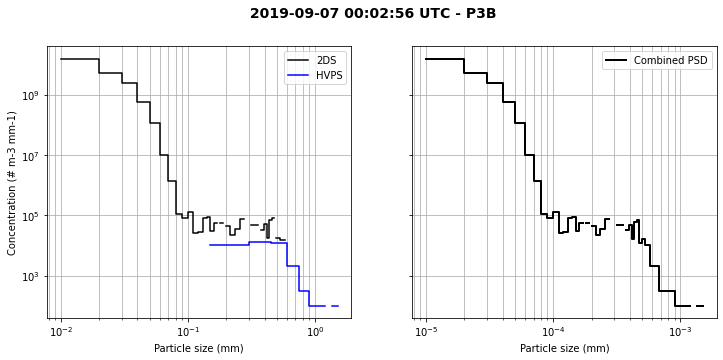

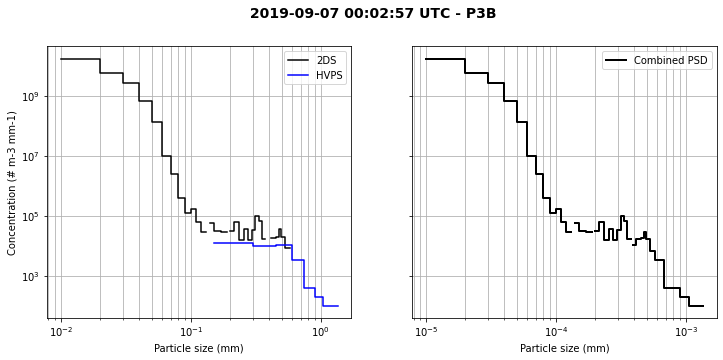

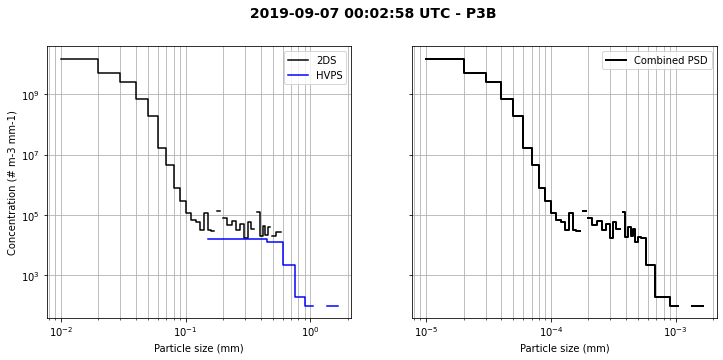

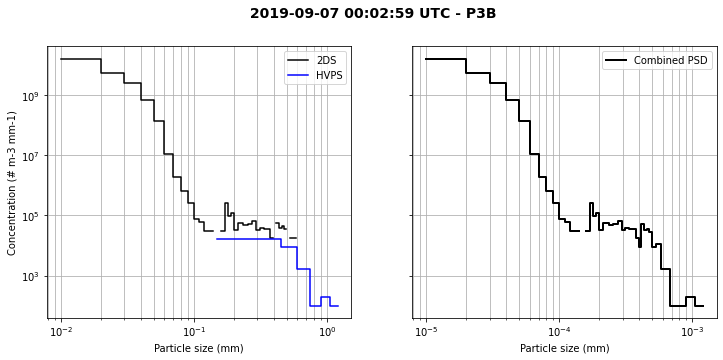

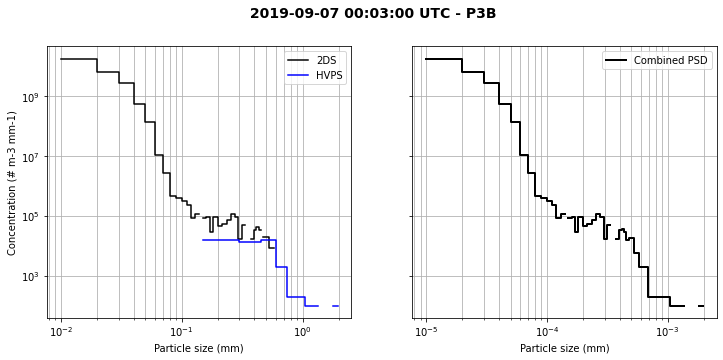

In [43]:
for i in xr_400.time.sel(time=slice('2019-09-07 00:02:00', '2019-09-07 00:03:00')):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    y = xr_400.merge_psd.sel(time=i)
    y = y.where(y > 0, np.nan)

    ax1.step(x=xr_400.diameter * 1e-3, y=y, where='post', c='k', lw=2, label= 'Combined PSD')
    
    y = xr_2ds.pds.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)

    ax.step(x=xr_2ds.diameter* 1e-3, y=y, where='post', label='2DS', c='k')

    y = xr_hvps.pds.sel(time=i) * 1e6
    y = y.where(y > 0, np.nan)
    ax.step(x=xr_hvps.diameter* 1e-3, y=y, where='post', label='HVPS', c='b')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Particle size (mm)')
    ax.set_ylabel('Concentration (# m-3 mm-1)')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax.legend()
    ax1.legend()

    ax1.set_xlabel('Particle size (mm)')
    title = f"{pd.to_datetime(i.values): %Y-%m-%d %X} UTC - {aircraft}"
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
#     ax1.set_ylabel('Concentration (# m-3 m-1)')
    ax1.grid(which='both')
    ax.grid(which='both')
    plt.show()

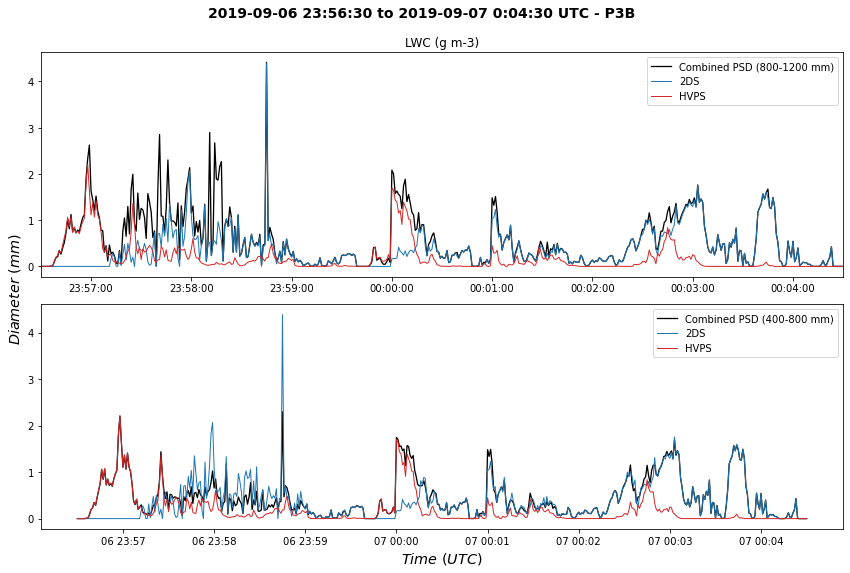

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), constrained_layout=True)

ax1.plot(LWC_800.time, LWC_800, label='Combined PSD (800-1200 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax1.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax1.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

ax2.plot(LWC_400.time, LWC_400, label='Combined PSD (400-800 mm)' , c='k', lw=1.3)
# ax2.plot(LWC_plane.time, LWC_plane, label='aircraft', c='C1', lw=1)
ax2.plot(LWC_2ds.time, LWC_2ds, label='2DS', c='C0', lw=1)
ax2.plot(LWC_hvps.time, LWC_hvps, label='HVPS', c='C3', lw=1)

#     ax1.ylabel(r'$Diameter \  (mm)$', fontsize='x-large')
fig.supylabel(r'$Diameter \  (mm)$', fontsize='x-large')
ax2.set_xlabel('$Time \  (UTC)$', fontsize='x-large')
ax1.set_title('$2DS$')
#     ax1.set_title('$N(D), \log_{10} (\# \ m^{-3} mm^{-1}) $', position=(0.8, 0.1), fontsize='x-large')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.set_title('LWC (g m-3)')
ax1.set_xlim(xr_400.time.sel(time=slice(start, end)).min(), xr_400.time.sel(time=slice(start, end)).max())
ax2.legend()
ax1.legend()

title = f"{start} to {end} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.99)
fig.tight_layout()